# Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import math

In [2]:
# Equation for Cleaning data

def clean_Sex(x):
    if x.lower() == "male" or x.lower() == "m" or x == 1:
        return "male"
    elif x.lower() == "female" or x.lower() == "f":
        return "female"

def fill_na(x):
    if math.isnan(x):
        return 0
    else:
        return x


In [3]:
#Read the data
df = pd.read_csv("TD_HOSPITAL_TRAIN.csv")
df.head()

,timeknown,cost,reflex,sex,blood,bloodchem1,bloodchem2,temperature,race,heart,psych1,glucose,psych2,dose,psych3,bp,bloodchem3,confidence,bloodchem4,comorbidity,totalcost,breathing,age,sleep,dnr,bloodchem5,pdeath,meals,pain,primary,psych4,disability,administratorcost,urine,diabetes,income,extraprimary,bloodchem6,education,psych5,psych6,information,cancer,death
0,4.0,3008.38867,11.228005,male,20.699219,2.199707,1.299805,35.59375,white,103.0,4.0,157.0,2.0,5,0.0,107.0,0.399963,4.403557,12.0,6.0,2471.7988,34.0,76.56396,7.519531,dnr before sadm,7.359375,NaN,142.0,2.0,Cirrhosis,NaN,<2 mo. follow-up,3525.0,5360.0,0.0,$11-$25k,COPD/CHF/Cirrhosis,167.5000,20.0,30.0,2.000,0.0,no,1.0
1,467.0,23585.89060,9.714861,M,9.398438,NaN,0.699951,39.00000,white,50.0,3.0,271.0,1.0,5,0.0,105.0,NaN,20.260360,10.0,1.0,20651.7812,26.0,63.33499,7.479492,no dnr,7.509766,NaN,132.0,3.0,Colon Cancer,0.0,NaN,43200.0,2570.0,0.0,>$50k,Cancer,480.0000,16.0,11.5,1.000,10.0,metastatic,1.0
2,533.0,4046.45898,11.353296,Male,19.296875,NaN,1.599854,38.19531,white,50.0,3.0,117.0,0.0,5,0.0,73.0,NaN,10.153806,28.0,3.0,4113.6797,13.0,70.52698,NaN,no dnr,7.459961,NaN,131.0,1.0,ARF/MOSF w/Sepsis,1.0,no(M2 and SIP pres),5894.0,1690.0,1.0,under $11k,ARF/MOSF,177.1250,5.0,18.0,0.000,5.0,yes,0.0
3,68.0,NaN,9.269058,female,7.500000,2.500000,0.599976,37.59375,white,80.0,4.0,NaN,NaN,5,0.0,120.0,3.699707,26.700676,NaN,1.0,9094.3281,18.0,55.31799,7.379883,no dnr,NaN,NaN,121.0,1.0,Cirrhosis,2.0,NaN,16717.0,NaN,0.0,$11-$25k,COPD/CHF/Cirrhosis,NaN,12.0,7.0,1.839,12.0,no,1.0
4,1605.0,6457.70703,8.655387,female,15.099609,4.399414,0.699951,35.69531,white,114.0,4.0,NaN,6.0,5,0.0,130.0,0.399963,9.962359,NaN,2.0,7150.9766,28.0,67.06598,7.429688,no dnr,7.449219,NaN,133.0,4.0,COPD,5.0,no(M2 and SIP pres),10151.0,NaN,0.0,under $11k,COPD/CHF/Cirrhosis,233.3125,2.0,7.0,6.000,12.0,no,0.0


In [4]:
unique_pdeath_values = df['pdeath'].unique()
unique_pdeath_values

array([nan])

In [5]:
df = df.drop(columns=['pdeath'])

In [6]:
#Apply fill_na to numeric columns
for col in df.columns:
    if df[col].dtype in [np.int64, np.float64]:
        df[col] = df[col].apply(fill_na)

In [7]:
#ONE HOT ENCODING

encoding_columns = ["sex", "dnr", "primary", "disability", "extraprimary", "cancer", "race"]

for i in encoding_columns:
    newCols = pd.get_dummies(df[i], prefix=i)
    df = pd.concat([df, newCols], axis=1)
    df = df.drop(columns=[i])


In [8]:
for i in df.columns:
    try:
        df[i] = df[i].astype(float)
    except ValueError:
        pass

In [9]:
#drop un important features
drop_cols = ["cost", "income"]
df = df.drop(columns=drop_cols)

In [10]:
#Save columns name and order for future prediction
df_cols = df.columns
df_cols

Index(['timeknown', 'reflex', 'blood', 'bloodchem1', 'bloodchem2',
       'temperature', 'heart', 'psych1', 'glucose', 'psych2', 'dose', 'psych3',
       'bp', 'bloodchem3', 'confidence', 'bloodchem4', 'comorbidity',
       'totalcost', 'breathing', 'age', 'sleep', 'bloodchem5', 'meals', 'pain',
       'psych4', 'administratorcost', 'urine', 'diabetes', 'bloodchem6',
       'education', 'psych5', 'psych6', 'information', 'death', 'sex_1',
       'sex_M', 'sex_Male', 'sex_female', 'sex_male', 'dnr_dnr after sadm',
       'dnr_dnr before sadm', 'dnr_no dnr', 'primary_ARF/MOSF w/Sepsis',
       'primary_CHF', 'primary_COPD', 'primary_Cirrhosis',
       'primary_Colon Cancer', 'primary_Coma', 'primary_Lung Cancer',
       'primary_MOSF w/Malig', 'disability_<2 mo. follow-up',
       'disability_Coma or Intub', 'disability_SIP>=30',
       'disability_adl>=4 (>=5 if sur)', 'disability_no(M2 and SIP pres)',
       'extraprimary_ARF/MOSF', 'extraprimary_COPD/CHF/Cirrhosis',
       'extraprima

# Model Training

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

In [12]:
#Get features and labels
y = df['death'] 
X = df.drop(columns=['death'])

In [13]:
# Scalling
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
rf = RandomForestClassifier()
param_grid_RF = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Perform GridSearchCV for hyperparameter tuning
rf_model = GridSearchCV(rf, param_grid_RF, cv=3, n_jobs=-1)
rf_model.fit(X_train, y_train)


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]})

In [16]:
y_pred_RF = rf_model.predict_proba(X_test)[:,1]

In [17]:
xgb = XGBClassifier()
param_grid_XGB = {
    'n_estimators': [50, 100, 200, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.2, 0.4, 0.7, 1],
    'max_depth': [3, 4, 5, 8, 10],
    'booster': ['gbtree', 'gblinear', 'dart']
}

xgb_model = GridSearchCV(xgb, param_grid_XGB, cv=3, n_jobs=-1)
xgb_model.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'booster': ['gbtree', 'gblinear', 'dart'],
                         'learning_rate': [0.01, 0.1, 0.2, 0.4, 0.7, 1],
                         'max_depth': [3, 4, 5, 8, 10],
                         'n_estimators': [50, 100, 200, 500, 1000]})

In [18]:
y_pred_XGB = xgb_model.predict_proba(X_test)[:,1]

In [19]:
ada = AdaBoostClassifier()

#Hypertunining
param_grid_ADA = {'n_estimators': [50, 100, 200, 300, 400, 500, 1000],
              'learning_rate': [ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
              'algorithm': ['SAMME', 'SAMME.R']}

#train with grid search
ada_model = GridSearchCV(ada, param_grid_ADA, cv=5)
ada_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                           0.8, 0.9, 1],
                         'n_estimators': [50, 100, 200, 300, 400, 500, 1000]})

In [21]:
y_pred_ADA = ada_model.predict_proba(X_test)[:,1]

In [23]:
rocauc_RF = roc_auc_score(y_test, y_pred_RF)
rocauc_XGB = roc_auc_score(y_test, y_pred_XGB)
rocauc_ADA = roc_auc_score(y_test, y_pred_ADA)
print("Random Forest: ", rocauc_RF)
print("XGBoost: ", rocauc_XGB)
print("AdaBoost: ", rocauc_ADA)

Random Forest:  0.962434662132376
XGBoost:  0.967978821984112
AdaBoost:  0.945410830117046


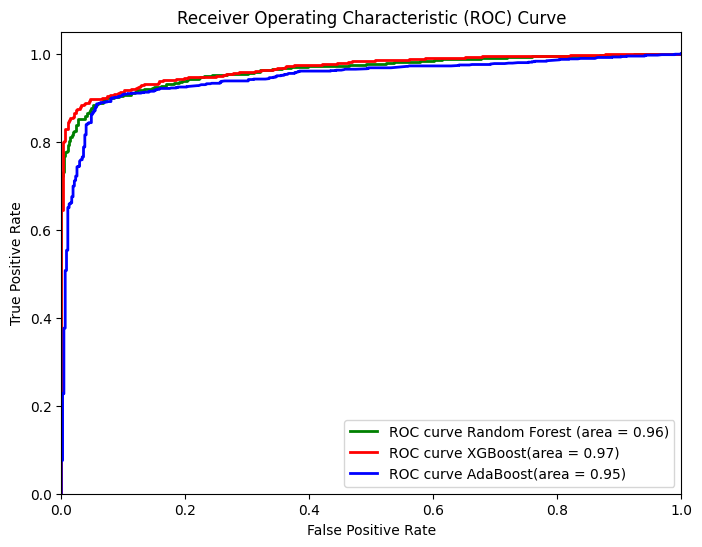

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_RF)
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_XGB)
fpr_ada, tpr_ada, thresholds_ada = roc_curve(y_test, y_pred_ADA)
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'ROC curve Random Forest (area = {rocauc_RF:.2f})')
plt.plot(fpr_xgb, tpr_xgb, color='red', lw=2, label=f'ROC curve XGBoost(area = {rocauc_XGB:.2f})')
plt.plot(fpr_ada, tpr_ada, color='blue', lw=2, label=f'ROC curve AdaBoost(area = {rocauc_ADA:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [27]:
import joblib
joblib.dump(rf_model, 'rf_model.pkl')
joblib.dump(xgb_model, 'xgb_model.pkl')
joblib.dump(ada_model, 'ada_model.pkl')

['ada_model.pkl']